# Unsupervised learning models

Unsupervised learning is area of machine learning focused on detecting patterns in the data and **modelling without explicitly set labels/target variable**. In contrast, supervised learning techniques are mainly based on predicting nominal features (classification) or continuous features (regression).

Main tasks in the area of unsupervised learning are:
- **dimensionality reduction**
- **clustering**
- anomaly detection

**Dimensionality reduction** algorithms aim to represent high-dimensional input data in the output space with lower dimensionality. The approach is useful for:
- visualization of high dimensional data
- removing noise
- lowering the volume of the dataset, hence improving performance of other algorithms
- obfuscating and anonymizing the data

**Clustering** aims to differentiate the groups within the data, usually based on the distance between the observations. It's common task for customer or product datasets - segments created based on clustering results may be used in marketing activities or as an input to supervised machine learning model.

Importing required libraries:

In [1]:
using MultivariateStats, RDatasets, Plots, StatsBase, LinearAlgebra, ClusterAnalysis
using UMAP: umap
using Statistics

## Dimensionality reduction

Loading a dataset:

In [2]:
data = dataset("datasets", "USArrests")

Row,State,Murder,Assault,UrbanPop,Rape
,String15,Float64,Int64,Int64,Float64
1,Alabama,13.2,236,58,21.2
2,Alaska,10.0,263,48,44.5
3,Arizona,8.1,294,80,31.0
4,Arkansas,8.8,190,50,19.5
5,California,9.0,276,91,40.6
6,Colorado,7.9,204,78,38.7
7,Connecticut,3.3,110,77,11.1
8,Delaware,5.9,238,72,15.8
9,Florida,15.4,335,80,31.9


Transforming a dataframe into numerical matrix structure, similarly to X matrix for predictive models composed of exogenous variables:

In [3]:
X_matrix = Matrix(data[:, 2:end])

50×4 Matrix{Float64}:
 13.2  236.0  58.0  21.2
 10.0  263.0  48.0  44.5
  8.1  294.0  80.0  31.0
  8.8  190.0  50.0  19.5
  9.0  276.0  91.0  40.6
  7.9  204.0  78.0  38.7
  3.3  110.0  77.0  11.1
  5.9  238.0  72.0  15.8
 15.4  335.0  80.0  31.9
 17.4  211.0  60.0  25.8
  5.3   46.0  83.0  20.2
  2.6  120.0  54.0  14.2
 10.4  249.0  83.0  24.0
  ⋮                 
  3.4  174.0  87.0   8.3
 14.4  279.0  48.0  22.5
  3.8   86.0  45.0  12.8
 13.2  188.0  59.0  26.9
 12.7  201.0  80.0  25.5
  3.2  120.0  80.0  22.9
  2.2   48.0  32.0  11.2
  8.5  156.0  63.0  20.7
  4.0  145.0  73.0  26.2
  5.7   81.0  39.0   9.3
  2.6   53.0  66.0  10.8
  6.8  161.0  60.0  15.6

Keeping US names in a seperate `labels` variable:

In [4]:
labels = Vector(data[:, 1])

50-element Vector{InlineStrings.String15}:
 "Alabama"
 "Alaska"
 "Arizona"
 "Arkansas"
 "California"
 "Colorado"
 "Connecticut"
 "Delaware"
 "Florida"
 "Georgia"
 "Hawaii"
 "Idaho"
 "Illinois"
 ⋮
 "Rhode Island"
 "South Carolina"
 "South Dakota"
 "Tennessee"
 "Texas"
 "Utah"
 "Vermont"
 "Virginia"
 "Washington"
 "West Virginia"
 "Wisconsin"
 "Wyoming"

Saving data dimensions to `obs_number` and `original_size` variables:

In [5]:
obs_number, original_size = size(X_matrix)

(50, 4)

## Principal Component Analysis (PCA)

We'll use PCA (Principal Components Analysis) technique to represent high dimensional data in 2-dimensional space and plot the result.

PCA is popular algorithm for dimensionality reduction based on linear algebra. For input matrix (dataset) we need to calculate eigenvectors (principal components) and eigenvalues. Eigenvectors determine directions for projection in new feature space and eigenvalues determine the mangnitude ('importance') of the vectors.

We start with an quick-and-easy simulated data set to generate visualisations which helps to explain the concept of PCA. Later, we move on to the real dataset.

In [6]:
corr = 0.9
n=1000
corr_mat = [1 corr;
            corr 1]
chol_decomp = cholesky(corr_mat).L
cor_data=[randn(n) randn(n)]*chol_decomp'
println("Correlation matrix: ", cor(cor_data))
println("Standard deviations: ", std(cor_data, dims=1))
print("Means: ", mean(cor_data, dims=1))


Correlation matrix: [1.0 0.8967113786872457; 0.8967113786872457 1.0]
Standard deviations: [0.9807658804644146 0.9812452265379675]
Means: [0.0278942336579621 0.013148488321190855]

In [7]:
fitted_PCA = fit(PCA, cor_data', maxoutdim = 2, mean=0)

PCA(indim = 2, outdim = 2, principalratio = 1.0)

Pattern matrix (unstandardized loadings):
──────────────────────
        PC1        PC2
──────────────────────
1  0.955466   0.223081
2  0.955651  -0.223038
──────────────────────

Importance of components:
──────────────────────────────────────────────
                                PC1        PC2
──────────────────────────────────────────────
SS Loadings (Eigenvalues)  1.82618   0.099511
Variance explained         0.948325  0.0516753
Cumulative variance        0.948325  1.0
Proportion explained       0.948325  0.0516753
Cumulative proportion      0.948325  1.0
──────────────────────────────────────────────

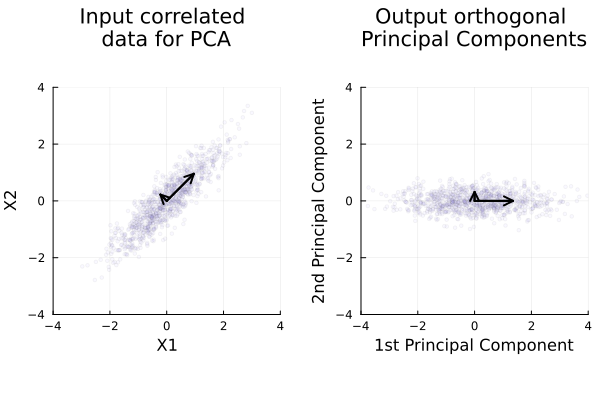

In [8]:
scatter(cor_data[:,1], cor_data[:,2], markeralpha=0.05, markercolor=:lightslateblue, rightmargin=5Plots.mm,
        ylim=(-4, 4), xlim = (-4, 4), aspect_ratio=:equal, markersize=2, layout=(1,2),
        xlabel="X1", ylabel = "X2", legend=false, title = "Input correlated \ndata for PCA")
quiver!(zeros(2), zeros(2),
        quiver=(loadings(fitted_PCA)[1,:], loadings(fitted_PCA)[2,:]), linewidth=2,
        c=:black)
scatter!(predict(fitted_PCA, cor_data')'[:,1],predict(fitted_PCA, cor_data')'[:,2],
        markeralpha=0.05, markercolor=:lightslateblue, subplot=2,
        ylim=(-4, 4), xlim = (-4, 4), aspect_ratio=:equal, markersize=2,
        xlabel="1st Principal Component", ylabel = "2nd Principal Component",
        legend=false, title = "Output orthogonal \nPrincipal Components")
quiver!(zeros(2), zeros(2),subplot=2,
        quiver=(predict(fitted_PCA, loadings(fitted_PCA))'[1,:],
                predict(fitted_PCA, loadings(fitted_PCA))'[2,:]),
        linewidth=2, c=:black)

PCA requires a data standarization to work properly. PCA on a non-standarized data will be biased towards variables with highest variance.

In [9]:
standarized_X_matrix = Matrix(mapcols(zscore, data[:,2:end]))

50×4 Matrix{Float64}:
  1.24256     0.782839  -0.520907   -0.00341647
  0.507862    1.10682   -1.21176     2.4842
  0.0716334   1.4788     0.99898     1.04288
  0.232349    0.230868  -1.07359    -0.184917
  0.278268    1.26281    1.75892     2.06782
  0.0257146   0.398859   0.860809    1.86497
 -1.03042    -0.729082   0.791723   -1.08174
 -0.433474    0.806838   0.446294   -0.579946
  1.74767     1.97078    0.99898     1.13897
  2.20686     0.482855  -0.382735    0.487702
 -0.57123    -1.49704    1.20624    -0.110181
 -1.19113    -0.609088  -0.79725    -0.75077
  0.5997      0.938831   1.20624     0.295525
  ⋮                                 
 -1.00746     0.038878   1.48258    -1.38068
  1.51808     1.29881   -1.21176     0.135378
 -0.915622   -1.01707   -1.41902    -0.900241
  1.24256     0.206869  -0.451821    0.605143
  1.12777     0.362861   0.99898     0.455672
 -1.05338    -0.609088   0.99898     0.178084
 -1.28297    -1.47304   -2.31714    -1.07106
  0.163471   -0.177111  -0.17

Fitting PCA on a transposed `standarized_X_matrix` with means equal to $0$:

In [10]:
fitted_PCA = fit(PCA, standarized_X_matrix';
                maxoutdim = original_size, mean=0)

PCA(indim = 4, outdim = 4, principalratio = 1.0)

Pattern matrix (unstandardized loadings):
─────────────────────────────────────────────
        PC1        PC2        PC3         PC4
─────────────────────────────────────────────
1  0.843976  -0.416035   0.20376    0.270371
2  0.918443  -0.187021   0.160119  -0.309592
3  0.438117   0.868328   0.225724   0.0557533
4  0.855839   0.16646   -0.488319   0.0370741
─────────────────────────────────────────────

Importance of components:
──────────────────────────────────────────────────────────────────
                               PC1       PC2        PC3        PC4
──────────────────────────────────────────────────────────────────
SS Loadings (Eigenvalues)  2.48024  0.989765  0.356563   0.17343
Variance explained         0.62006  0.247441  0.0891408  0.0433575
Cumulative variance        0.62006  0.867502  0.956642   1.0
Proportion explained       0.62006  0.247441  0.0891408  0.0433575
Cumulative proportion      0.62006  0.867502  0.956642

#### Questions:
- What's the interpretation of loadings?
- Why loadings are unstandarized? what it means to be standarized here?
- What's the interpretation of Eigenvalues?
- Explain the 'Importance of components' table in a business language.                

In [11]:
standarized_loadings = LinearAlgebra.eigvecs(fitted_PCA)[:,1:2]

4×2 Matrix{Float64}:
 -0.535899  -0.418181
 -0.583184  -0.187986
 -0.278191   0.872806
 -0.543432   0.167319

In [12]:
standarized_loadings = LinearAlgebra.eigvecs(fitted_PCA)[:,1:2]

4×2 Matrix{Float64}:
 -0.535899  -0.418181
 -0.583184  -0.187986
 -0.278191   0.872806
 -0.543432   0.167319

Now you can predict Principal Components (also knows as embedding). You can think of Principal Components as new features characterizing observations. Usually you'll neeed signficanlty less number of Principal Compenents than original number of columns to represent the significant share of information (variance) repsented in an original dataset.

In [13]:
PrincipalComponents = predict(fitted_PCA, standarized_X_matrix')

4×50 Matrix{Float64}:
 -0.97566   -1.93054   -1.74544    …   2.08739    2.05881    0.623101
 -1.122     -1.06243    0.73846       -1.41053    0.605125  -0.317787
 -0.439804   2.0195     0.0542302      0.103722  -0.137469  -0.23824
  0.154697  -0.434175  -0.826264       0.130583   0.182253  -0.164977

Both `predict` and `MultivariateStats.transform` will produce Pricipal Components - you can think of those as encoding the original features:

In [14]:
PrincipalComponents == MultivariateStats.transform(fitted_PCA, standarized_X_matrix') #encoding

true

In [15]:
PC_limit = ceil(Int, maximum(abs.(PrincipalComponents)))

3

In [16]:
UStates_visualization = [ (PrincipalComponents'[i,1], PrincipalComponents'[i,2],
                        text(data.State[i], 6, :blue)) for i=1:obs_number ]

50-element Vector{Tuple{Float64, Float64, Plots.PlotText}}:
 (-0.9756604483336052, -1.1220012104334114, Plots.PlotText("Alabama", Plots.Font("sans-serif", 6, :hcenter, :vcenter, 0.0, RGB{N0f8}(0.0,0.0,1.0))))
 (-1.9305378785136833, -1.062426919534446, Plots.PlotText("Alaska", Plots.Font("sans-serif", 6, :hcenter, :vcenter, 0.0, RGB{N0f8}(0.0,0.0,1.0))))
 (-1.7454428533905986, 0.7384595372849986, Plots.PlotText("Arizona", Plots.Font("sans-serif", 6, :hcenter, :vcenter, 0.0, RGB{N0f8}(0.0,0.0,1.0))))
 (0.1399989443485946, -1.108542259505911, Plots.PlotText("Arkansas", Plots.Font("sans-serif", 6, :hcenter, :vcenter, 0.0, RGB{N0f8}(0.0,0.0,1.0))))
 (-2.4986128482585808, 1.5274267208247923, Plots.PlotText("California", Plots.Font("sans-serif", 6, :hcenter, :vcenter, 0.0, RGB{N0f8}(0.0,0.0,1.0))))
 (-1.4993407374655237, 0.9776296565249825, Plots.PlotText("Colorado", Plots.Font("sans-serif", 6, :hcenter, :vcenter, 0.0, RGB{N0f8}(0.0,0.0,1.0))))
 (1.344992364946849, 1.0779836152260323, Plots.P

In [17]:
loadings_visualization = [ text(names(data)[i], 10, :orange, :right) for i=1:original_size ]

4-element Vector{Plots.PlotText}:
 Plots.PlotText("State", Plots.Font("sans-serif", 10, :right, :vcenter, 0.0, RGB{N0f8}(1.0,0.647,0.0)))
 Plots.PlotText("Murder", Plots.Font("sans-serif", 10, :right, :vcenter, 0.0, RGB{N0f8}(1.0,0.647,0.0)))
 Plots.PlotText("Assault", Plots.Font("sans-serif", 10, :right, :vcenter, 0.0, RGB{N0f8}(1.0,0.647,0.0)))
 Plots.PlotText("UrbanPop", Plots.Font("sans-serif", 10, :right, :vcenter, 0.0, RGB{N0f8}(1.0,0.647,0.0)))

So-called **biplot** is the important visualization tool of PCA. Biplot dipsplays both the **pricipal componenets score** (observations, e.g. states) and the **principal component loadings**, i.e. coefficients/weights defining each of Principal Components and enabling the interpretation of Pricipal Components also in a business langaguage. Below is the **biplot** for our PCA:

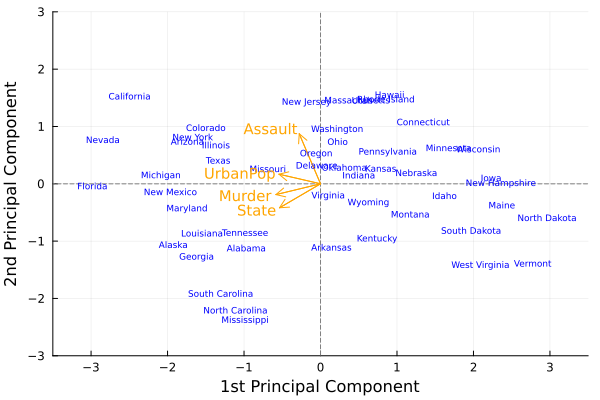

In [18]:
# Replication of FIGURE 12.1 on p. 502 from https://hastie.su.domains/ISLR2/ISLRv2_website.pdf
plot( ; annotations= UStates_visualization , legend = false,
    xlim=[-PC_limit-.5,PC_limit+.5], ylim=[-PC_limit, PC_limit],
    xlabel = "1st Principal Component",
    ylabel = "2nd Principal Component")
hline!([0],line=:dash, color=:grey)
vline!([0],line=:dash, color=:grey)
quiver!(zeros(original_size),
        zeros(original_size),
        quiver=(standarized_loadings[:,1],standarized_loadings[:,2]),
        c=:orange)
annotate!(standarized_loadings[:,1]*1.1, 1.1*standarized_loadings[:,2], loadings_visualization)

#### Questions:
- Is the plot the same as in FIGURE 12.1?
- If not, why is so? is it a problem?

How efficient is reduction? How much information, i.e. variance, is "encoded" in low-dimentional embedding?

In [19]:
explained_variance = LinearAlgebra.eigvals(fitted_PCA)

4-element Vector{Float64}:
 2.4802415791494923
 0.9897651525398412
 0.35656318058082925
 0.1734300877298352

Both `LinearAlgebra.eigvals()` and `principalvars()` generate sequence of decreasing variance explained by corresponding Principal Component:

In [20]:
explained_variance == principalvars(fitted_PCA)

true

Why does `explained_variance` sum to the number of features? 

In [21]:
sum(explained_variance)

3.9999999999999982

It's more convenient also in business terms to talk about the proportion of explained Variance (the same way we prefer to speak about $R^2$ - coefficient of determination rather than Mean Squared Error) rather than absolute value of total variance being explained, so we calculate `propOfExplainedVariance`: 

In [22]:
propOfExplainedVariance = explained_variance ./ sum(explained_variance)

4-element Vector{Float64}:
 0.6200603947873733
 0.2474412881349604
 0.08914079514520735
 0.04335752193245882

Below is the replication of **FIGURE 12.3** from page 507 from [**An Introduction to Statistical Learning**](https://hastie.su.domains/ISLR2/ISLRv2_website.pdf):
- on the left: so called  **scree plot** depicting the proportion of variance explained by each of prciipal components
- on the right: the cumulative proportion of variance explained by principal components.

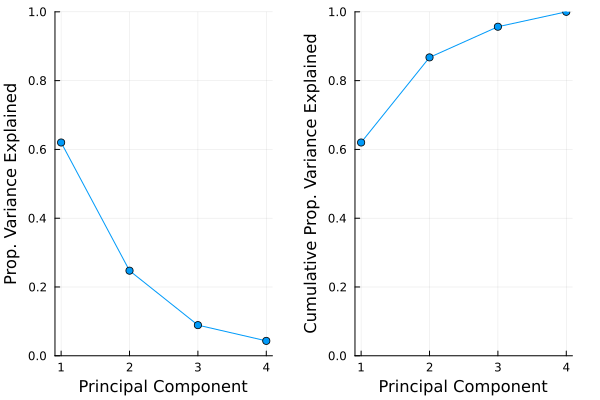

In [23]:
plot(1:length(explained_variance), 
    Matrix( [propOfExplainedVariance  cumsum(propOfExplainedVariance)]),
    ylim = [0,1],marker=:circle, layout=(1,2),legend = false,
    xlabel = "Principal Component", rightmargin=5Plots.mm,
    ylabel = ["Prop. Variance Explained" "Cumulative Prop. Variance Explained"])

You might want to use your reduced number of Principal Components to predict `original_size` features and see how good your PCA is able to recover original variance. This process is called "decoding":

In [24]:
recovered_original_space_obs = reconstruct(fit(PCA, standarized_X_matrix';
                                                maxoutdim = 2, mean=0),
                                            PrincipalComponents[1:2,:])'

50×4 adjoint(::Matrix{Float64}) with eltype Float64:
  0.992055   0.779909   -0.70787     0.342473
  1.47886    1.32558    -0.390235    0.871352
  0.626572   0.879094    1.1301      1.07209
  0.388546   0.126745   -1.00649    -0.26156
  0.700265   1.17002     2.02824     1.61339
  0.39467    0.690611    1.27038     0.978366
 -1.17157   -0.987023    0.566706   -0.550545
 -0.109381  -0.0330044   0.29426     0.0795577
  1.6147     1.7468      0.795882    1.61443
  1.39912    1.1844     -0.6536      0.670045
 -1.13431   -0.819154    1.10559    -0.230856
 -0.782598  -0.907432   -0.63388    -0.917109
  0.449263   0.669188    0.968879    0.854751
  ⋮                                 
 -1.07589   -0.776327    1.05124    -0.217557
  1.50105    1.12228    -1.30681     0.390267
 -0.713695  -0.994366   -1.25882    -1.20574
  0.886501   0.737263   -0.467963    0.395342
  0.548161   0.70559     0.729596    0.797346
 -0.901253  -0.591695    1.11981    -0.0524522
 -0.90567   -1.35636    -1.98312    -1.

Let's visualize how well 2-dimensional PCA is able to reconstruct 4-dimensional original set:

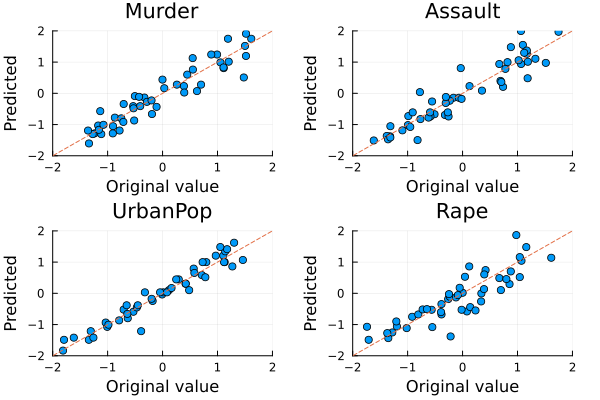

In [25]:
gr(display_type=:inline) # to adjust bottom margin in order not to overlap with titles of lower row of plot
scatter(recovered_original_space_obs,
        standarized_X_matrix,
        layout = (2, 2), rightmargin=5Plots.mm,
        ylabel = "Predicted",
        xlabel = "Original value",
        title=["Murder" "Assault" "UrbanPop" "Rape"],
        legend = false, xlim=(-2,2), ylim=(-2,2))
Plots.abline!(1, 0, line=:dash,  subplot = 1)
Plots.abline!(1, 0, line=:dash,  subplot = 2)
Plots.abline!(1, 0, line=:dash,  subplot = 3)
Plots.abline!(1, 0, line=:dash,  subplot = 4)

PCA exploits the correlation between features, which means that variables bring similar information to each other and this information can be represented (encoded, embedded) in Principal Components. If features were orthogonal (not correlated) to each other, the would be no sense and value-added from using PCA. Luckily, typicaly in observational (in comparison to experimental) socio-economic data there's a lot of correlated variables as you can see bellow in a following correlation matrix:

In [26]:
cor(standarized_X_matrix)

4×4 Matrix{Float64}:
 1.0        0.801873  0.0695726  0.563579
 0.801873   1.0       0.258872   0.665241
 0.0695726  0.258872  1.0        0.411341
 0.563579   0.665241  0.411341   1.0

### Summary of Principal Component Analysis (PCA)
- New representation in lower dimensional space (e.g. less than 10 or 2 for visuall purposes) is achieved via linear combination of original features (usually more than 100) and loadings
- PCA exploits the correlation between features. The would be no sens and no value-added of using PCA, if variables were orthoghonal, i.e. idealy independent.
- PCA is equivalent to deep learning autoencoder with linear activation functions
- PCA requires data standarization, as its ommision will results in relative focus on variables with higher variance
- even though PCA results of Principal Components don't have direct interpretation, they can be thought as indices being composed of original features and being able to represent high dimenstional (often >100) dataset by less than 10 Principal Components 

## Uniform Manifold Approximation & Projection (UMAP)
Now let's try a modern dimensionality reduction algorithm called **UMAP** (Uniform Manifold Approximation & Projection). It is rooted in Riemannian geometry - details can be found in the [paper](https://arxiv.org/abs/1802.03426). UMAP proved to give really good results and is considered state-of-the-art.

Function `umap` returns a new data representation into 2-dimentional embedding. An important input parameter is `n_neighbors`:

In [27]:
UMAP_embedding = umap(standarized_X_matrix', n_neighbors = 10)'

50×2 adjoint(::Matrix{Float64}) with eltype Float64:
 -2.9497     -0.0576204
 -0.838564    0.226788
 -0.0496523   0.599286
  4.12882    -1.25781
  0.104779    0.0472485
 -0.0564212  -0.0667391
  3.51866    -2.96247
  3.74979    -1.8116
 -0.798563    0.808226
 -3.26875    -0.231415
  2.7868     -2.19708
  5.30203    -2.95652
  0.503842    0.565844
  ⋮          
  2.96929    -2.7784
 -2.81405     0.149307
  5.93556    -3.12936
 -3.32477    -0.0818782
  0.524713    0.538065
  2.43373    -2.03401
  6.40484    -3.56055
  3.58289    -1.1481
  2.49592    -1.56393
  6.29032    -3.21653
  4.7223     -3.46959
  4.01234    -1.44856

As previously, we set up a vector composed of 50 states describing its embedding coordinates and graphical parameters:

In [28]:
UStates_visualization = [ (UMAP_embedding[i,1], UMAP_embedding[i,2],
                        text(data.State[i], 6, :blue)) for i=1:obs_number ]

50-element Vector{Tuple{Float64, Float64, Plots.PlotText}}:
 (-2.949701060501332, -0.05762044861374262, Plots.PlotText("Alabama", Plots.Font("sans-serif", 6, :hcenter, :vcenter, 0.0, RGB{N0f8}(0.0,0.0,1.0))))
 (-0.8385644475875368, 0.2267884967128428, Plots.PlotText("Alaska", Plots.Font("sans-serif", 6, :hcenter, :vcenter, 0.0, RGB{N0f8}(0.0,0.0,1.0))))
 (-0.04965225155089707, 0.5992864293861582, Plots.PlotText("Arizona", Plots.Font("sans-serif", 6, :hcenter, :vcenter, 0.0, RGB{N0f8}(0.0,0.0,1.0))))
 (4.128818797748285, -1.257812869956224, Plots.PlotText("Arkansas", Plots.Font("sans-serif", 6, :hcenter, :vcenter, 0.0, RGB{N0f8}(0.0,0.0,1.0))))
 (0.1047789101812303, 0.04724853292877494, Plots.PlotText("California", Plots.Font("sans-serif", 6, :hcenter, :vcenter, 0.0, RGB{N0f8}(0.0,0.0,1.0))))
 (-0.05642121794664404, -0.06673911715235455, Plots.PlotText("Colorado", Plots.Font("sans-serif", 6, :hcenter, :vcenter, 0.0, RGB{N0f8}(0.0,0.0,1.0))))
 (3.5186625376967835, -2.9624674969171556, Pl

Finally, we draw a two-dimensional scatterplot with our observations of US states into embedded space: 

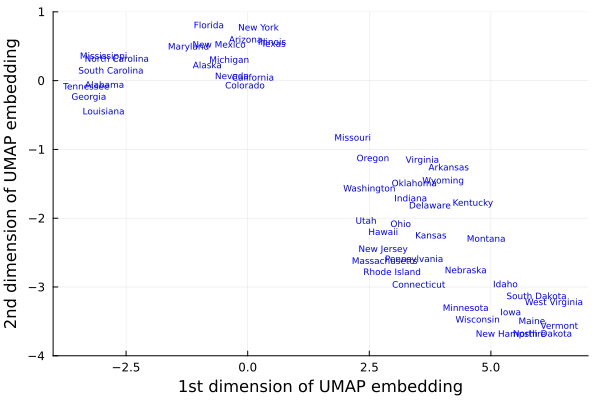

In [29]:
#PC_limit = ceil(Int, maximum(PrincipalComponents))
plot( ; annotations= UStates_visualization , legend = false,
    xlim=[floor(Int, minimum(UMAP_embedding[:,1])), ceil(Int, maximum(UMAP_embedding[:,1]))],
    ylim=[floor(Int, minimum(UMAP_embedding[:,2])), ceil(Int, maximum(UMAP_embedding[:,2]))],
    xlabel = "1st dimension of UMAP embedding",
    ylabel = "2nd dimension of UMAP embedding")


## Clustering
### k-means algorithm

K-means algorithm in the nutshell:
1. Pick randomly 'k' observations from the dataset - initial centroids
2. Assign other observations to the nearest centroid
3. Calculate average coordinates from the members of the clusters - new coordinates of the center
4. Repeat 2. and 3. until stop criterion is reached

We start with a simple and simulated dataset demonstrating the potential Data Generating Process for k-mean algorithm and how it can be applied to this dataset. We start with defining two basic data generation parameters:

In [30]:
n_per_cluster = 100
true_centroids = [(2, 2), (6, 6), (2,6), (6,2)]


4-element Vector{Tuple{Int64, Int64}}:
 (2, 2)
 (6, 6)
 (2, 6)
 (6, 2)

Data Generating Process (DGP):

In [31]:
observations = (true_centroids[1] .+ randn(2,n_per_cluster))'
for centroid_number in 2:length(true_centroids)
    observations = vcat(observations, (true_centroids[centroid_number] .+ randn(2,n_per_cluster))')
end

Generated data visualization:

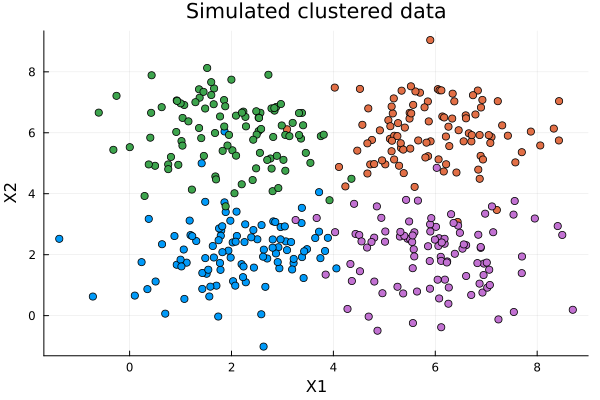

In [32]:
scatter(observations[:,1], observations[:,2], color=repeat(1:length(true_centroids),
        inner=n_per_cluster), xlab="X1", ylab="X2", legend=false, title="Simulated clustered data")

Fitting k-means algorithm:

In [33]:
fitted_kmeans=kmeans(observations, 4, nstart = 100, maxiter = 100)


KmeansResult{Float64}:
 K = 4
 centroids = [
     [5.9510367554264905, 6.02593165429462]
     [2.1447984517028096, 2.1448870128754973]
     [6.0333111309918825, 2.019284142834287]
     [1.9554489425618613, 6.0897419976818155]
 ]
 cluster = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
 within-cluster sum of squares = 774.2203278624675
 iterations = 6

Visualization of k-means clustering:

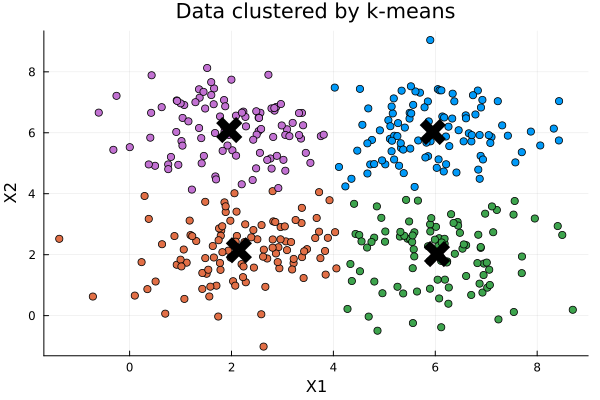

In [34]:
scatter(observations[:,1], observations[:,2], color=fitted_kmeans.cluster,
        xlabel="X1", ylab="X2", legend = false, title="Data clustered by k-means")
estimated_centroids = reduce(hcat, fitted_kmeans.centroids)
scatter!(estimated_centroids[1,:], estimated_centroids[2,:],markershape=:xcross,
        markersize = 10, markercolor=:black, msw=11)

Generating an artificial dense prediction set to create a classification regeions:

In [35]:
denseset_n=10000
denseset=[8*rand(denseset_n) rand(denseset_n)*8]
predicted_cluster=[argmin(sum((denseset[i,:] .- estimated_centroids) .^2, dims = 1))[2] for i in 1:denseset_n]

10000-element Vector{Int64}:
 1
 3
 3
 3
 2
 1
 2
 1
 3
 4
 1
 1
 2
 ⋮
 4
 4
 4
 2
 4
 1
 4
 4
 2
 1
 1
 2

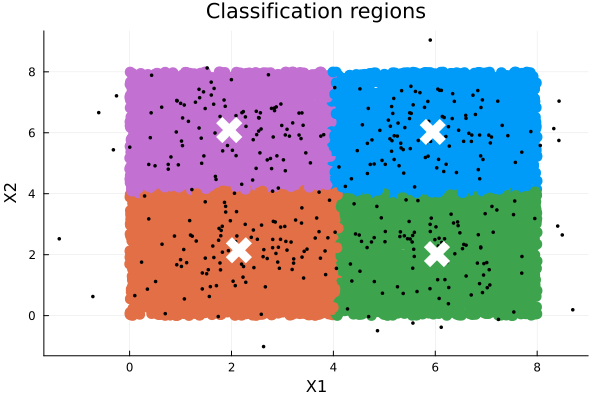

In [36]:
scatter(denseset[:,1], denseset[:,2], color=predicted_cluster, xlabel="X1", ylab="X2",
        markersize=6, msw=0,title="Classification regions", legend=false)
scatter!(observations[:,1], observations[:,2],
        color=:black, xlabel="X1", ylab="X2", markersize=2)
scatter!(estimated_centroids[1,:], estimated_centroids[2,:],markershape=:xcross,
        markersize = 10, markercolor=:white, msw=11)

Then we move to a real-world dataset:

In [37]:
fitted_kmeans=kmeans(standarized_X_matrix, 4, nstart = 100, maxiter = 100)

KmeansResult{Float64}:
 K = 4
 centroids = [
     [1.3037892173564183, 0.694843916699676, -0.8279544274797356, -0.04137728429474474]
     [0.6950701018424226, 1.0394414063397852, 0.7226370276556853, 1.276939640119023]
     [-0.4894375435723546, -0.38260013154448236, 0.5758297921137798, -0.2616537888096655]
     [-1.0782511319167984, -1.137060952333547, -0.9296640155022322, -1.003446595161662]
 ]
 cluster = [1, 2, 2, 1, 2, 2, 3, 3, 2, 1  …  4, 1, 2, 3, 4, 3, 3, 4, 4, 3]
 within-cluster sum of squares = 56.40317345829281
 iterations = 7

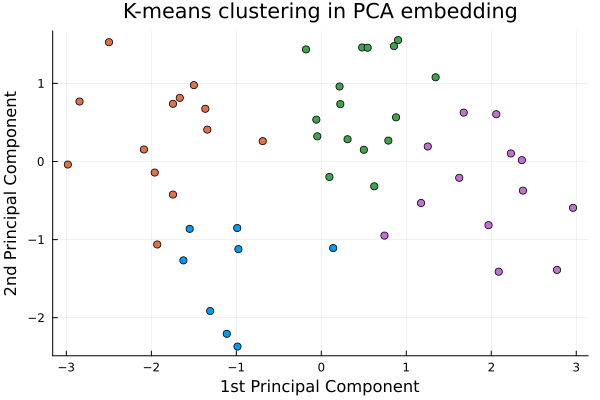

In [38]:
scatter(PrincipalComponents'[:,1], PrincipalComponents'[:,2], color=fitted_kmeans.cluster, legend = false,
xlabel = "1st Principal Component",
ylabel = "2nd Principal Component",
title = "K-means clustering in PCA embedding")

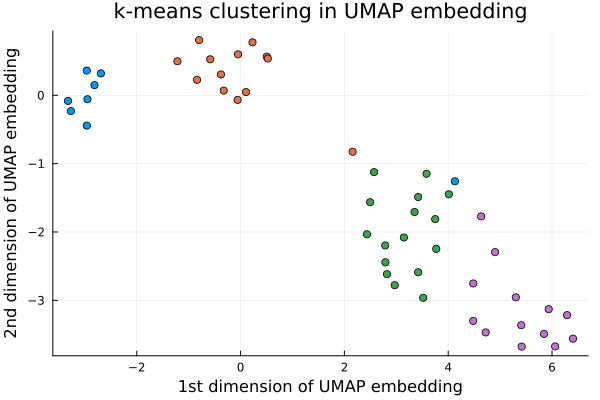

In [39]:
scatter(UMAP_embedding[:,1], UMAP_embedding[:,2], color=fitted_kmeans.cluster, legend = false,
xlabel = "1st dimension of UMAP embedding",
ylabel = "2nd dimension of UMAP embedding",
title = "k-means clustering in UMAP embedding")

**Elbow** method to pick k - inertia for given k-means clustering is the sum of squares between clusters' center and their members

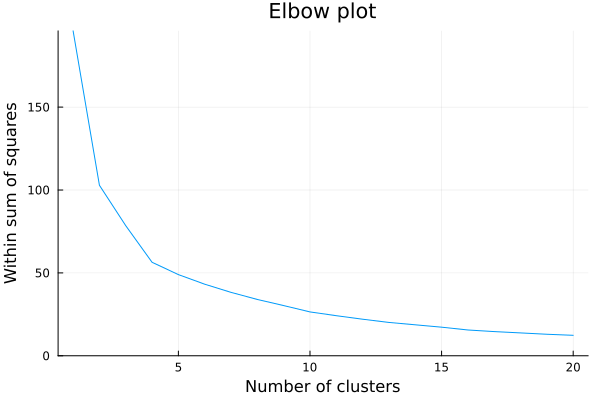

In [40]:
max_number_of_clusters = 20
within_sum_squares=[kmeans(standarized_X_matrix, k, nstart=500, maxiter=100).withinss
                    for k in 1:max_number_of_clusters]
plot(1:max_number_of_clusters, within_sum_squares,
    ylim=(0,within_sum_squares[1]), legend = false,
    xlabel = "Number of clusters",
    ylabel = "Within sum of squares",
    title = "Elbow plot")

### Summary of k-means algorithm
- k-means might a support segmentation exercise, but resulted segments will heavily depend on the subjective selection of input variables and number of segments K. These should be specified rather by a subject matter expert rather than a data scientist. Segmentation is more an art than a science and therfore rather not so easy task.
- requires data standarization, since no standarization will result in clusters defined accros variables with high variables
- each run of k-means algorithm starts with a randomized starting points, i.e. cluster centroids, so the results might differ from run to run
- since k-means is not global optimization method, it might identify local solution, so it's important to allow an algorithm to be rerun multiple times with different starting points, i.e. cluster centroids

*Preparation of this workshop has been supported by the Polish National Agency for Academic Exchange under the Strategic Partnerships programme, grant number BPI/PST/2021/1/00069/U/00001.*

![SGH & NAWA](../logo.png)